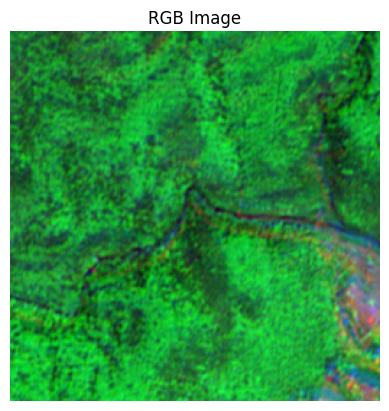

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio


image_path = '1\\1_01_41.tif'


with rasterio.open(image_path) as src:

    r = src.read(2)  
    g = src.read(3) 
    b = src.read(1) 


rgb_image = np.stack([r, g, b], axis=-1)


def normalize(image, new_min=0, new_max=1):
    old_min = np.min(image)
    old_max = np.max(image)
    normalized = (image - old_min) / (old_max - old_min)  
    return normalized


r_normalized = normalize(r)
g_normalized = normalize(g)
b_normalized = normalize(b)


rgb_image_normalized = np.stack([r_normalized, g_normalized, b_normalized], axis=-1)


plt.imshow(rgb_image_normalized)
plt.title('RGB Image')
plt.axis('off') 
plt.show()



In [23]:
import rasterio
from rasterio.features import geometry_mask
from rasterio.transform import from_bounds
import geopandas as gpd
import numpy as np
import os


images_folder = 'Train//1//'
shapefile_path = 'Train\\1\\1.shp'
output_folder = 'Train\\output_masks'


roads_gdf = gpd.read_file(shapefile_path)


def generate_binary_mask(image_path, roads_gdf, output_path):
    
    with rasterio.open(image_path) as src:
        image = src.read(1) 
        image_bounds = src.bounds  
        image_transform = src.transform  
        image_crs = src.crs  
        image_shape = src.shape 
        
       
        roads_gdf = roads_gdf.to_crs(image_crs)
        
        
        geometries = roads_gdf.geometry
        
        
        mask = geometry_mask(geometries, transform=image_transform, invert=True, out_shape=image_shape)

        
        mask_output_path = os.path.join(output_path, os.path.basename(image_path))
        with rasterio.open(
            mask_output_path,
            'w',
            driver='GTiff',
            height=mask.shape[0],
            width=mask.shape[1],
            count=1,
            dtype=np.uint8, 
            crs=image_crs,
            transform=image_transform,
        ) as dst:
            dst.write(mask.astype(np.uint8), 1)
    
    print(f"Mask saved at: {mask_output_path}")


for filename in os.listdir(images_folder):
    if filename.endswith('.tif'):  
        image_path = os.path.join(images_folder, filename)
        generate_binary_mask(image_path, roads_gdf, output_folder)


Mask saved at: output_masks\1_01_01.tif
Mask saved at: output_masks\1_01_02.tif
Mask saved at: output_masks\1_01_03.tif
Mask saved at: output_masks\1_01_04.tif
Mask saved at: output_masks\1_01_05.tif
Mask saved at: output_masks\1_01_06.tif
Mask saved at: output_masks\1_01_07.tif
Mask saved at: output_masks\1_01_08.tif
Mask saved at: output_masks\1_01_09.tif
Mask saved at: output_masks\1_01_10.tif
Mask saved at: output_masks\1_01_11.tif
Mask saved at: output_masks\1_01_12.tif
Mask saved at: output_masks\1_01_13.tif
Mask saved at: output_masks\1_01_14.tif
Mask saved at: output_masks\1_01_15.tif
Mask saved at: output_masks\1_01_16.tif
Mask saved at: output_masks\1_01_17.tif
Mask saved at: output_masks\1_01_18.tif
Mask saved at: output_masks\1_01_19.tif
Mask saved at: output_masks\1_01_20.tif
Mask saved at: output_masks\1_01_21.tif
Mask saved at: output_masks\1_01_22.tif
Mask saved at: output_masks\1_01_23.tif
Mask saved at: output_masks\1_01_24.tif
Mask saved at: output_masks\1_01_25.tif


In [24]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, UpSampling2D, BatchNormalization, Activation, Concatenate, Input
from tensorflow.keras.models import Model


def build_resnet50_unet(input_shape=(256, 256, 3), num_classes=1):

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    

    skip1 = base_model.get_layer("conv1_relu").output     
    skip2 = base_model.get_layer("conv2_block3_out").output 
    skip3 = base_model.get_layer("conv3_block4_out").output 
    skip4 = base_model.get_layer("conv4_block6_out").output 


    bottleneck = base_model.get_layer("conv5_block3_out").output  # 8x8


    up1 = UpSampling2D(size=(2, 2))(bottleneck)
    up1 = Conv2D(512, (3, 3), padding="same")(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation("relu")(up1)
    up1 = Concatenate()([up1, skip4])


    up2 = UpSampling2D(size=(2, 2))(up1)
    up2 = Conv2D(256, (3, 3), padding="same")(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation("relu")(up2)
    up2 = Concatenate()([up2, skip3])


    up3 = UpSampling2D(size=(2, 2))(up2)
    up3 = Conv2D(128, (3, 3), padding="same")(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation("relu")(up3)
    up3 = Concatenate()([up3, skip2])

    up4 = UpSampling2D(size=(2, 2))(up3)
    up4 = Conv2D(64, (3, 3), padding="same")(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation("relu")(up4)
    up4 = Concatenate()([up4, skip1])


    up5 = UpSampling2D(size=(2, 2))(up4)
    up5 = Conv2D(32, (3, 3), padding="same")(up5)
    up5 = BatchNormalization()(up5)
    up5 = Activation("relu")(up5)


    outputs = Conv2D(num_classes, (1, 1), padding="same", activation="sigmoid")(up5)


    model = Model(inputs=base_model.input, outputs=outputs)
    
    return model


input_shape = (256, 256, 3)

model = build_resnet50_unet(input_shape=input_shape, num_classes=1)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()






Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                      

In [ ]:
import rasterio
import cv2
import numpy as np
import os


image_dir = 'Train\\1\\'
mask_dir = 'Train\\output_masks\\'


def load_image_and_mask(image_path, mask_path, target_size=(256, 256)):
    with rasterio.open(image_path) as src:
        image = src.read([2, 3, 1])  
        image = np.moveaxis(image, 0, -1) 
        image = cv2.resize(image, target_size)  
        image = image / 255.0  

    
    with rasterio.open(mask_path) as mask_src:
        mask = mask_src.read(1)  
        mask = cv2.resize(mask, target_size)
        mask = np.expand_dims(mask, axis=-1)  
        mask = mask / 255.0  

    return image, mask

def create_dataset(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []


    for filename in os.listdir(image_dir):
        if filename.endswith(".tif"):
            image_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename)
            image, mask = load_image_and_mask(image_path, mask_path, target_size)
            images.append(image)
            masks.append(mask)

    return np.array(images), np.array(masks)


X, y = create_dataset(image_dir, mask_dir)

model.fit(X, y, batch_size=8, epochs=25, validation_split=0.2)
model.save('resnet50_unet_model.h5')